In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [26]:
train = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv')
original = pd.read_csv('/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv')

In [27]:
original['Depression'] = original['Depression'].map({"Yes": 1, "No": 0})

df = pd.concat([train, original], ignore_index=True)

for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

for col in test.select_dtypes(include='object').columns:
    test[col] = test[col].astype('category')

X = df.drop('Depression', axis=1)
Y = df['Depression']


In [28]:
df.head()


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0.0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1.0,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2.0,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3.0,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4.0,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


# Imbalanced Data

In [29]:
df.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0.0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1.0,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2.0,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3.0,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4.0,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [30]:
df['Depression'].value_counts()

Depression
0    117234
1     26022
Name: count, dtype: int64

In [31]:
import seaborn as sns

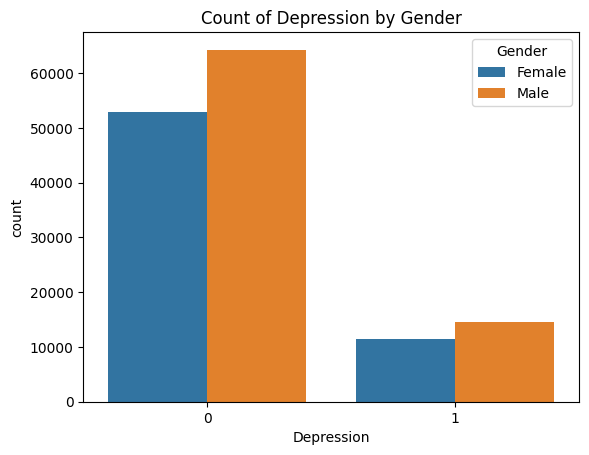

In [32]:
sns.countplot(x="Depression" , data=df ,hue= 'Gender' )
plt.title("Count of Depression by Gender")
plt.show()

# EDA

**Gender vs Depression**

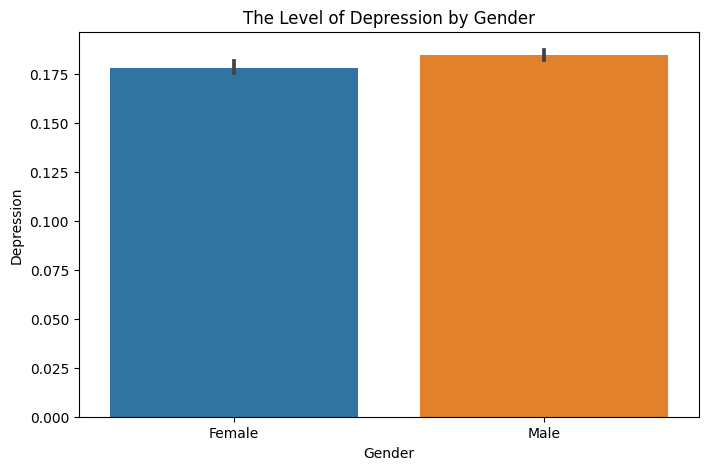

In [33]:
plt.figure(figsize=(8,5))
sns.barplot(x=df['Gender'], y=df['Depression'])
plt.title("The Level of Depression by Gender")
plt.show()

> The chart shows that both genders experience similar levels of depression, with a slightly higher average for males. This indicates that, on average, depression levels do not vary significantly by gender in this dataset

In [34]:
Most_Cities_Have_Depression = pd.DataFrame(df["City"].value_counts().head(10))
Most_Cities_Have_Depression

,count
City,
Kalyan,6683
Patna,6013
Vasai-Virar,5860
Kolkata,5776
Ahmedabad,5705
Meerut,5629
Ludhiana,5314
Pune,5308
Rajkot,5303


df3) Working Professional or Student vs Depression**

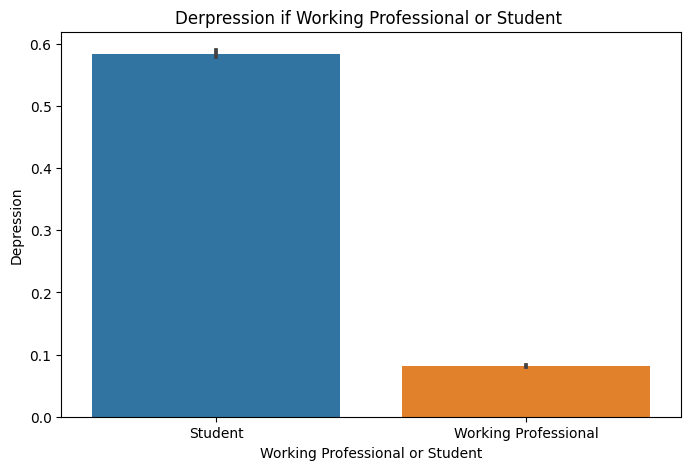

In [35]:
plt.figure(figsize=(8,5))
sns.barplot(x='Working Professional or Student', y='Depression', data=df)
plt.title("Derpression if Working Professional or Student ")
plt.show()

> The data clearly indicates that students experience higher levels of depression compared to working professionals. Let's investigate the possible reasons behind this difference.

**4) Profession vs Depression**

In [36]:
most10_professions_With_depression = pd.DataFrame(df["Profession"].value_counts().head(10))
most10_professions_With_depression

,count
Profession,
Teacher,25228
Content Writer,7930
Architect,4443
Consultant,4301
HR Manager,4106
Pharmacist,3968
Doctor,3321
Business Analyst,3232
Entrepreneur,3031


> teachers have a higher levels of depression, along with a few other professions that might be misclassified in this dataset. It appears that individuals with more unstructured time may be more prone to depressive thoughts compared to those who are occupied with work, as they may lack the mental engagement that comes with a busy schedule. This aligns with the saying, 'An idle mind is the devil's workshop

**5) Age vs Depression**

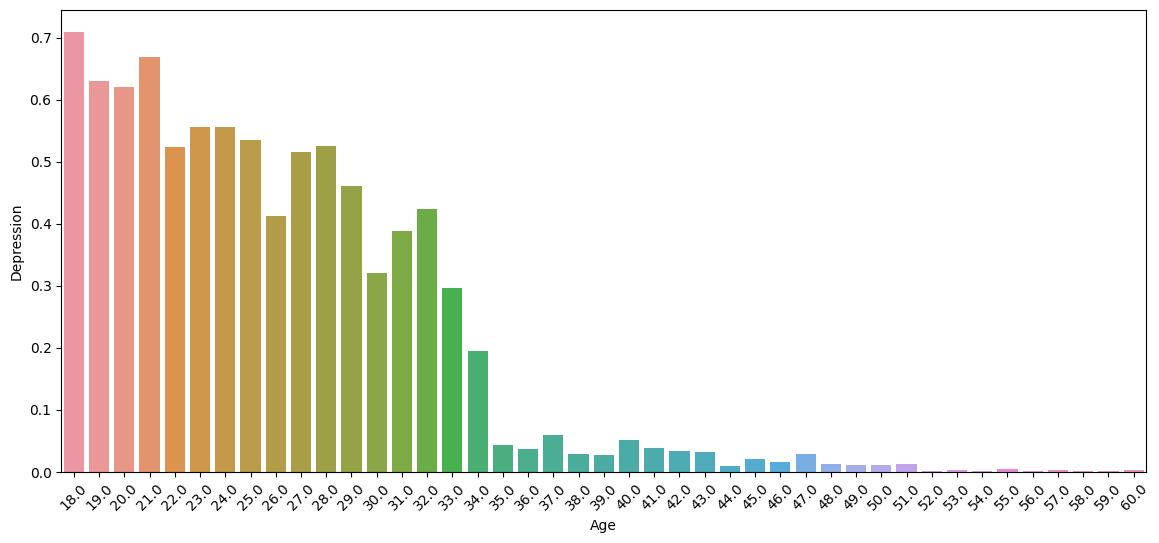

In [37]:
plt.figure(figsize=(14,6))
Age_depression_proportion = df.groupby('Age')['Depression'].mean().reset_index()
sns.barplot(x='Age', y='Depression', data=Age_depression_proportion)
plt.xticks(rotation=45)
plt.show()

> This data indicates that younger individuals are more susceptible to depression than older ones. As age increases, levels of depression tend to decrease, suggesting a negative correlation between age and depression. This trend may reflect various factors, younger people often face unique stressors related to academic, career, and social pressures, which can contribute to higher rates of depression. Older individuals, on the other hand, might have greater life stability, more coping mechanisms, and a stronger sense of self, which could buffer against depressive symptoms. Understanding these trends could help in tailoring mental health interventions for different age groups.

**6) Academic Pressure vs Depression**

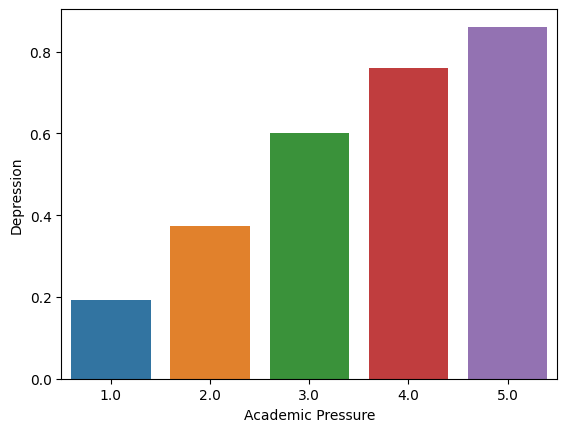

In [38]:
depression_proportion = df.groupby('Academic Pressure')['Depression'].mean().reset_index()
sns.barplot(x='Academic Pressure', y='Depression', data=depression_proportion)
plt.show()

> Based on the chart, there is a clear positive correlation between academic pressure and depression levels. As academic pressure increases, the average depression score also rises, suggesting that higher academic demands may be associated with increased mental health challenges among students.

**7) Work Pressure vs Depression**

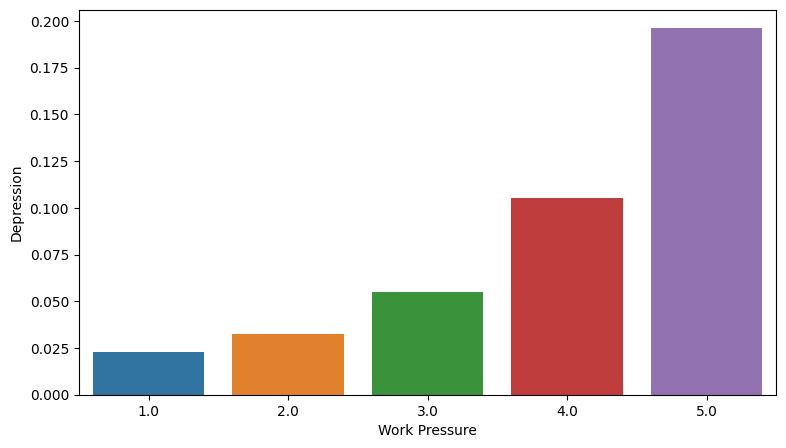

In [39]:
plt.figure(figsize=(9,5))
work_pressure_depression_proportion = df.groupby('Work Pressure')['Depression'].mean().reset_index()
sns.barplot(x='Work Pressure', y='Depression', data=work_pressure_depression_proportion)
plt.show()

> The bar chart illustrates a positive correlation between work pressure and depression levels. As work pressure increases, employees tend to experience higher levels of depression. This trend is comparable to patterns observed in academic pressure, where increasing demands can lead to mental health challenges. High work pressure often results from employees being assigned workloads beyond their capacity, limiting their ability to engage in social activities or personal time. This lack of balance can exacerbate feelings of isolation and stress, further impacting mental well-being.

**8) CGPA vs Depression**

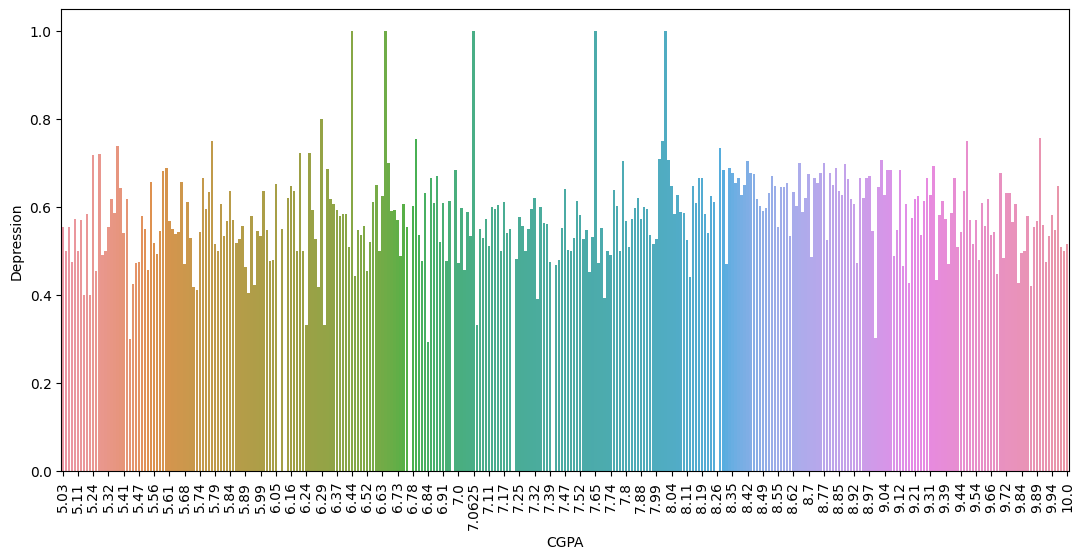

In [40]:
plt.figure(figsize=(13,6))
CGPA_proportion = df.groupby('CGPA')['Depression'].mean().reset_index()
sns.barplot(x='CGPA', y='Depression', data=CGPA_proportion)
plt.xticks(ticks=CGPA_proportion.index[::5], labels=CGPA_proportion['CGPA'][::5], rotation=90)
plt.show()

> The chart indicates that depression levels vary across CGPA ranges, without a clear linear trend. Students with both high and low CGPAs show notable levels of depression, suggesting that factors beyond academic performance, such as academic pressure or personal challenges, may influence depression across the spectrum of CGPA values.

**9) Study Satisfaction vs Depression**

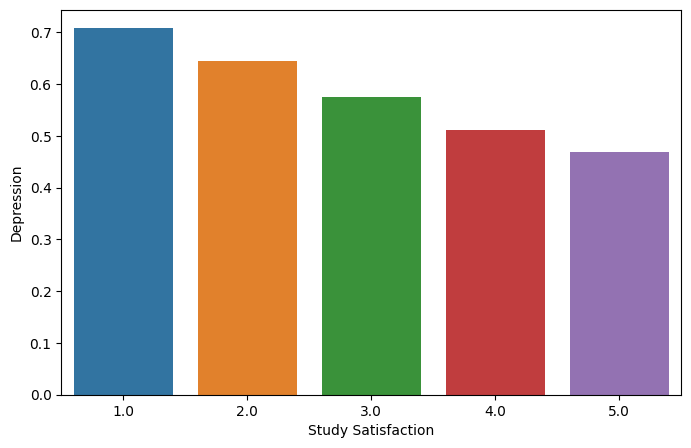

In [41]:
plt.figure(figsize=(8,5))
study_proportion = df.groupby('Study Satisfaction')['Depression'].mean().reset_index()
sns.barplot(x='Study Satisfaction', y='Depression', data=study_proportion)
plt.show()

We can see a beautfil negative correlation, where a student satisfaction on study decreases the Depression. Well it is true, if we look at students who dont study and on exam time they start studying trying to cover the whole syllabus in one night, taking pressure, gets depressed and also fails.

**10) Sleep Duration vs Depression**

> The data descriptions for "Sleep Duration" are indeed inconsistent and misleading, as they include unrelated or ambiguous categories. This makes it difficult to interpret which sleep duration correlates with higher depression levels accurately

> So I grouped them into categories, but still there is ambiguity in the data.

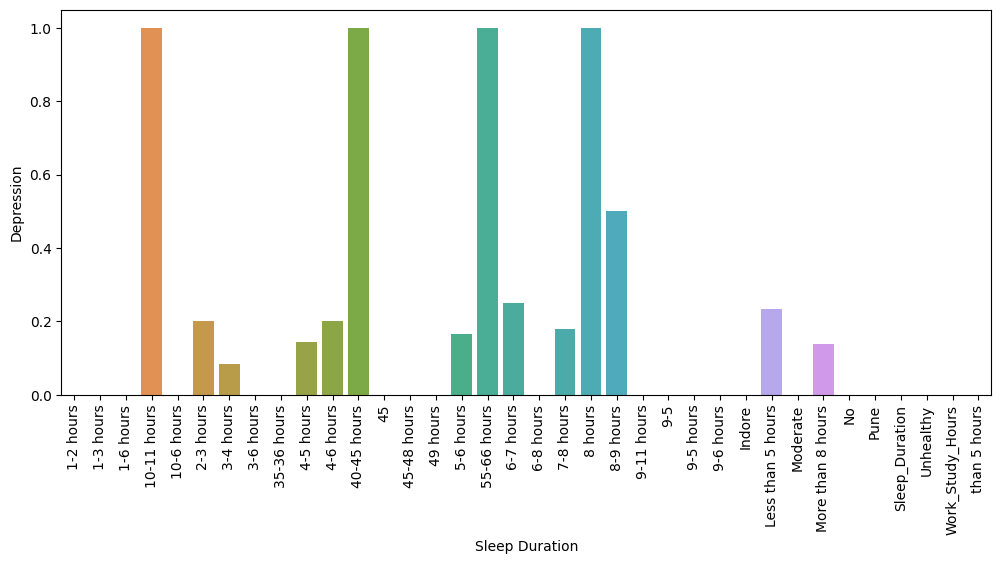

In [42]:
plt.figure(figsize=(12,5))
sleep_proportion = df.groupby('Sleep Duration')['Depression'].mean().reset_index()
sns.barplot(x='Sleep Duration', y='Depression', data=sleep_proportion)
plt.xticks(ticks=sleep_proportion.index[::1], labels=sleep_proportion['Sleep Duration'][::1], rotation=90)
plt.show()

> The chart suggests an inconsistent pattern in the relationship between sleep duration and depression levels. Although 8 hours of sleep shows a significant peak in depression, other durations do not follow a clear trend. Additionally, some categories overlap or seem unclear (e.g., "9-6 hours," "9-5," and ">8 hours"), which complicates the interpretation.

**11) Job Satisfaction vs Depression**

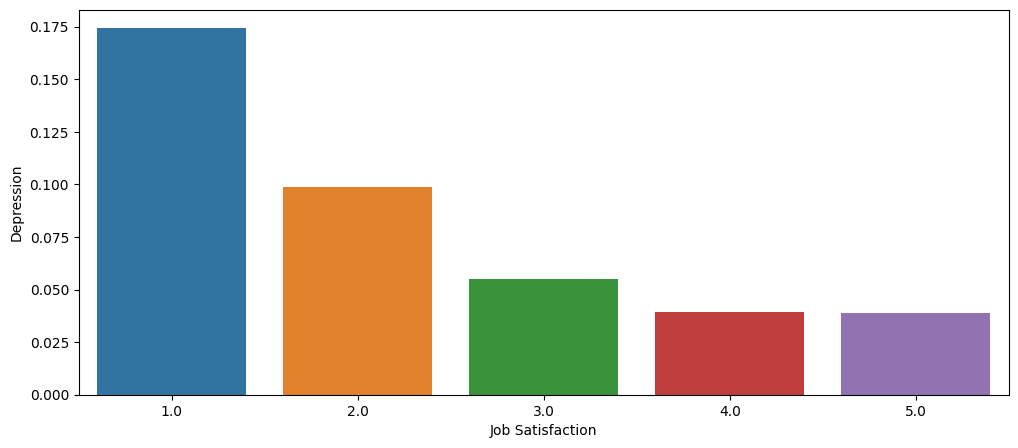

In [43]:
plt.figure(figsize=(12,5))
job_proportion = df.groupby('Job Satisfaction')['Depression'].mean().reset_index()
sns.barplot(x='Job Satisfaction', y='Depression', data=job_proportion)
plt.xticks(ticks=job_proportion.index[::1], labels=job_proportion['Job Satisfaction'][::1] )
plt.show()

> The chart shows a negative relationship between job satisfaction and depression levels. Higher job satisfaction scores (from 1 to 5) are associated with lower average depression levels. This suggests that individuals with higher job satisfaction tend to report fewer depression symptoms, highlighting the potential impact of job satisfaction on mental well-being.

**12) Dietary Habits vs Depression**

Data contains unnecassry data, labelled ambigious data with none 

In [44]:
irrelevant_labels_for_dietary = [ "Yes", "Pratham" ,"BSc", "Gender", "M.Tech" ,"Male", "Indoor", "Class 12", "Vegas", "No", "2","Mihir","1.0", "3"]
df['Dietary Habits'] = df['Dietary Habits'].replace(irrelevant_labels_for_dietary, "None")

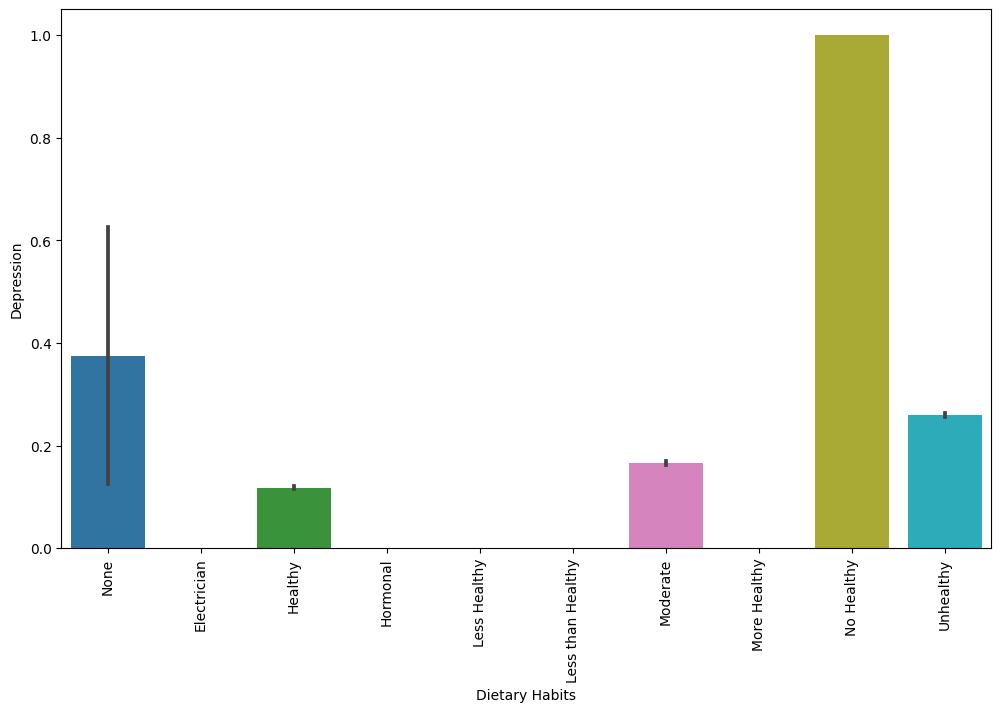

In [45]:
plt.figure(figsize=(12,7))
sns.barplot(x='Dietary Habits', y='Depression', data=df)
plt.xticks(rotation=90)
plt.show()

> Based on the chart, it appears that depression levels vary across dietary habits. Healthier dietary choices correlate with lower average depression scores, while moderate and unhealthy diets are associated with slightly higher depression levels

**13) Degree vs Depression**

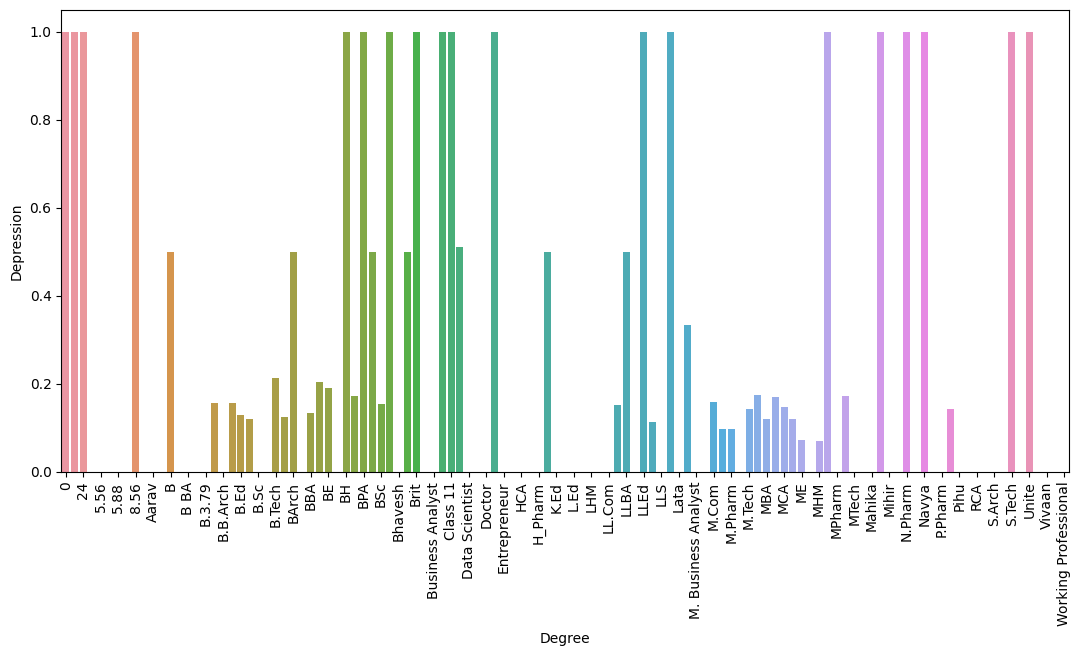

In [46]:
plt.figure(figsize=(13,6))
Degree_proportion = df.groupby('Degree')['Depression'].mean().reset_index()
sns.barplot(x='Degree', y='Depression', data=Degree_proportion)
plt.xticks(ticks=Degree_proportion.index[::2], labels=Degree_proportion['Degree'][::2], rotation=90)
plt.show()

> Alot of mislablled data is present, makes it very hard to interpret the data

**14) Have you ever had suicidal thoughts ?**

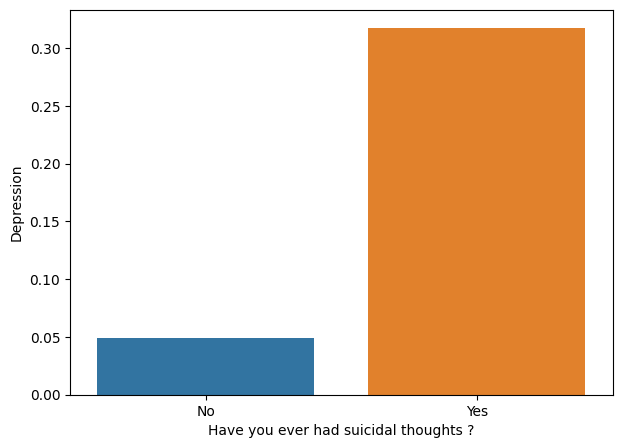

In [47]:
plt.figure(figsize=(7,5))
suicidal_proportion = df.groupby('Have you ever had suicidal thoughts ?')['Depression'].mean().reset_index()
sns.barplot(x='Have you ever had suicidal thoughts ?', y='Depression', data=suicidal_proportion)
plt.show()

**15) Work/Study Hours**

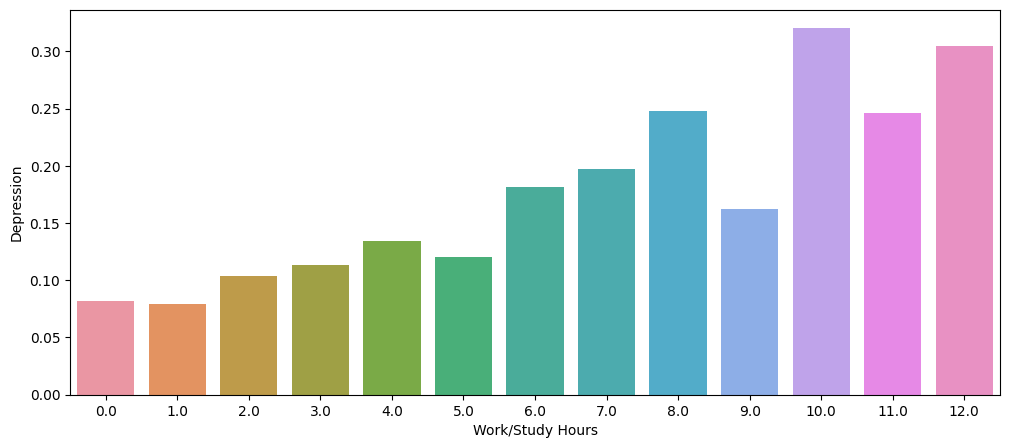

In [48]:
plt.figure(figsize=(12,5))
work_proportion = df.groupby('Work/Study Hours')['Depression'].mean().reset_index()
sns.barplot(x='Work/Study Hours', y='Depression', data=work_proportion)
plt.xticks(ticks=work_proportion.index[::1], labels=work_proportion['Work/Study Hours'][::1] )
plt.show()

> quite Amazing! The amount of study/work increase, the depression also increases. Should people study/ work less? will that cure there depression? what else PRODUCTIVE a person can do other than study? learning something grows an individually.

**16) Financial Stress**

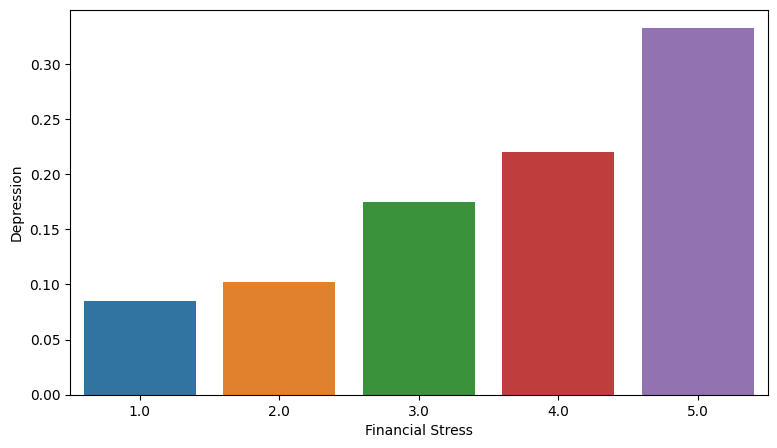

In [49]:
plt.figure(figsize=(9,5))
FinancialStress_proportion = df.groupby('Financial Stress')['Depression'].mean().reset_index()
sns.barplot(x='Financial Stress', y='Depression', data=FinancialStress_proportion)
plt.xticks(ticks=FinancialStress_proportion.index[::1], labels=FinancialStress_proportion['Financial Stress'][::1] )
plt.show()

> chart makes a clear cut sense! As an individual struggles financially, the depression tends to increase, when it is hard for thier needs to be fullfilled

**17) Family History of Mental Illness**

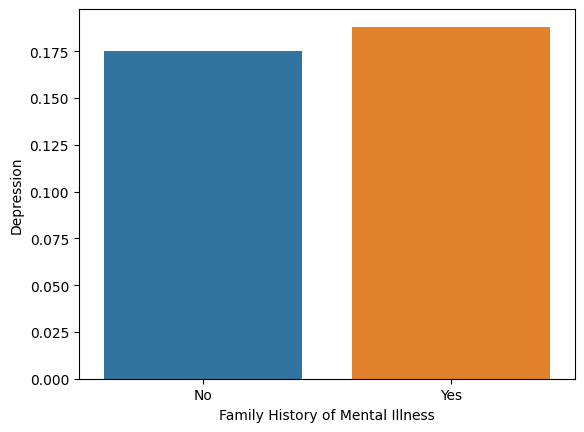

In [50]:
Mental_Illness_proportion = df.groupby('Family History of Mental Illness')['Depression'].mean().reset_index()
sns.barplot(x='Family History of Mental Illness', y='Depression', data=Mental_Illness_proportion)
plt.xticks(ticks=Mental_Illness_proportion.index[::1], labels=Mental_Illness_proportion['Family History of Mental Illness'][::1])
plt.show()


In [51]:
print("Have any NaN Values?? \n" , df.isnull().values.any())

Have any NaN Values?? 
 True


In [52]:
df.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0.0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1.0,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2.0,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3.0,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4.0,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143256 entries, 0 to 143255
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype   
---  ------                                 --------------   -----   
 0   id                                     140700 non-null  float64 
 1   Name                                   143256 non-null  category
 2   Gender                                 143256 non-null  category
 3   Age                                    143256 non-null  float64 
 4   City                                   143256 non-null  category
 5   Working Professional or Student        143256 non-null  category
 6   Profession                             105953 non-null  category
 7   Academic Pressure                      28399 non-null   float64 
 8   Work Pressure                          114836 non-null  float64 
 9   CGPA                                   28400 non-null   float64 
 10  Study Satisfaction                     28399

In [54]:
print("Which columns have NaN Values \n" , df.isna().sum())

Which columns have NaN Values 
 id                                         2556
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                37303
Academic Pressure                        114857
Work Pressure                             28420
CGPA                                     114856
Study Satisfaction                       114857
Job Satisfaction                          28412
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: i

# **To Fill the NaN Values**

In [55]:
from sklearn.impute import SimpleImputer

In [56]:
mean_impute = SimpleImputer(missing_values=np.nan , strategy="mean")

In [57]:
df["Academic Pressure"]=mean_impute.fit_transform(df["Academic Pressure"].values.reshape(-1,1))
df["Work Pressure"]=mean_impute.fit_transform(df["Work Pressure"].values.reshape(-1,1))
df["CGPA"]=mean_impute.fit_transform(df["CGPA"].values.reshape(-1,1))
df["Study Satisfaction"]=mean_impute.fit_transform(df["Study Satisfaction"].values.reshape(-1,1))
df["Job Satisfaction"]=mean_impute.fit_transform(df["Job Satisfaction"].values.reshape(-1,1))
df["Study Satisfaction"]=mean_impute.fit_transform(df["Study Satisfaction"].values.reshape(-1,1))




In [58]:
print("Have any NaN Values?? \n" , df.isnull().values.any())

Have any NaN Values?? 
 True


In [59]:
print("Which columns have NaN Values \n" , df.isna().sum())

Which columns have NaN Values 
 id                                        2556
Name                                         0
Gender                                       0
Age                                          0
City                                         0
Working Professional or Student              0
Profession                               37303
Academic Pressure                            0
Work Pressure                                0
CGPA                                         0
Study Satisfaction                           0
Job Satisfaction                             0
Sleep Duration                               0
Dietary Habits                               4
Degree                                       2
Have you ever had suicidal thoughts ?        0
Work/Study Hours                             0
Financial Stress                             4
Family History of Mental Illness             0
Depression                                   0
dtype: int64


In [60]:
from sklearn.preprocessing import LabelEncoder

In [61]:
df["Profession"] = LabelEncoder().fit_transform(df["Profession"])
df["Dietary Habits"] = LabelEncoder().fit_transform(df["Dietary Habits"])
df["Degree"] = LabelEncoder().fit_transform(df["Degree"])
df["Family History of Mental Illness"] = LabelEncoder().fit_transform(df["Family History of Mental Illness"])


In [62]:
most_freq_impute = SimpleImputer(missing_values=np.nan , strategy="most_frequent")

In [63]:
df["Profession"] = most_freq_impute.fit_transform(df["Profession"].values.reshape(-1,1))
df["Dietary Habits"] = most_freq_impute.fit_transform(df["Dietary Habits"].values.reshape(-1,1))
df["Degree"] = most_freq_impute.fit_transform(df["Degree"].values.reshape(-1,1))
df["Family History of Mental Illness"] = most_freq_impute.fit_transform(df["Family History of Mental Illness"].values.reshape(-1,1))


In [64]:
print("Now Have any NaN Values?? \n" , df.isnull().values.any())

Now Have any NaN Values?? 
 True


In [65]:
print("Which columns have NaN Values \n" , df.isna().sum())

Which columns have NaN Values 
 id                                       2556
Name                                        0
Gender                                      0
Age                                         0
City                                        0
Working Professional or Student             0
Profession                                  0
Academic Pressure                           0
Work Pressure                               0
CGPA                                        0
Study Satisfaction                          0
Job Satisfaction                            0
Sleep Duration                              0
Dietary Habits                              0
Degree                                      0
Have you ever had suicidal thoughts ?       0
Work/Study Hours                            0
Financial Stress                            4
Family History of Mental Illness            0
Depression                                  0
dtype: int64


In [66]:
df["Depression"]=mean_impute.fit_transform(df["Depression"].values.reshape(-1,1))
df["Financial Stress"]=mean_impute.fit_transform(df["Financial Stress"].values.reshape(-1,1))


In [67]:
print("Now Have any NaN Values?? \n" , df.isnull().values.any())

Now Have any NaN Values?? 
 True


# baseline

In [68]:
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: Depression, dtype: int64

In [69]:
Y = most_freq_impute.fit_transform(Y.values.reshape(-1,1))

In [70]:
X.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,0.0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No
1,1.0,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No
2,2.0,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No
3,3.0,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes
4,4.0,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes


In [71]:
X_train, X_dev, Y_train, Y_dev = train_test_split(df, Y, train_size=0.8, random_state=42)

model = lgb.LGBMClassifier(verbose=-1)

model.fit(X_train, Y_train)

train_predictions = model.predict(X_train)
training_acc = accuracy_score(Y_train, train_predictions)
print('Training accuracy' , training_acc*100 , "%")

prediction_score = model.predict(X_dev)

dev_acc = accuracy_score(Y_dev, prediction_score)
print('Dev accuracy' ,  dev_acc*100 , "%")

Training accuracy 100.0 %
Dev accuracy 100.0 %


**LeaderBoard Score: 0.94040**

# Now lets refine our Model

In [73]:
params = {'max_depth': 10, 'learning_rate': 0.09035696113725614, 'n_estimators': 546, 'num_leaves': 8, 'subsample': 0.9184303358960701,
          'lambda_l2': 3.6809916176520234, 'colsample_bytree': 0.18108283990213297}  


categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

model = lgb.LGBMClassifier(**params, verbosity=-1)

model.fit(X_train, Y_train, categorical_feature=categorical_features)

from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in X_train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_dev[col] = le.transform(X_dev[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le
X_train = pd.get_dummies(X_train)
X_dev = pd.get_dummies(X_dev)
test = pd.get_dummies(test)

# التأكد من تطابق الأعمدة
X_dev = X_dev.reindex(columns=X_train.columns, fill_value=0)
test = test.reindex(columns=X_train.columns, fill_value=0)
X_train, X_dev = X_train.align(X_dev, join='left', axis=1, fill_value=0)
test = test.reindex(columns=X_train.columns, fill_value=0)
model.fit(X_train, Y_train)
train_predictions = model.predict(X_train)
training_acc = accuracy_score(Y_train, train_predictions)
print(f'Training accuracy: {training_acc}')

prediction_score = model.predict(X_dev)
dev_acc = accuracy_score(Y_dev, prediction_score)
print(f'Dev accuracy: {dev_acc}')

test_pred = model.predict(test)

result = pd.DataFrame({
    'id': test['id'],
    'Depression': test_pred
})

result.to_csv('Predictions.csv', index=False)


Training accuracy: 1.0
Dev accuracy: 1.0
